In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
import time

from data_utils import load_CIFAR10


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
!mkdir datasets
!bash get_datasets.sh 

--2019-05-10 20:10:26--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M   865KB/s    in 3m 19s  

2019-05-10 20:13:44 (839 KB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    # TODO: set the proper path to teh dataset
    cifar10_dir = '../../Resources/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    print(X_train.shape)
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

(49000, 32, 32, 3)
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


# Task 1: Softmax and Cross Entropy Loss

In [4]:
def softmax_naive(W, X):
    """
    (1P)
    Softmax function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.

    Returns:
    - class probabilities of shape (N, C)
    """
    # Initialize the loss and gradient to zero.
    probabilities = np.zeros((X.shape[0], W.shape[1]), dtype=np.float)

    #############################################################################
    # TODO: Compute the softmax using explicit loops.                           #
    # If you are not careful here, it is easy to run into numeric instability.  #
    #############################################################################
    for i in range(len(X)):
        sum = 0
        for j in range(len(W[0])):
            sum += np.exp(np.dot(X[i, :], W[:, j]))

        for w in range(len(W[0])):
            probabilities[i][w] = np.exp(np.dot(X[i, :], W[:, w])) / sum
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return probabilities


def softmax_loss_naive(W, X, y, reg):
    """
    (1P)
    Softmax (Cross Entropy) loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    prop = softmax_naive(W, X)
    for i in range(len(prop)):
        loss += (y[i] * -np.log(prop[i][y[i]]))
    loss = loss / len(prop)
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW


def softmax_vectorized(W, X):
    """
    (1P)
    Softmax function, vectorized version (without loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.

    Returns:
    - class probabilities of shape (N, C)
    """
    # Initialize the loss and gradient to zero.
    probabilities = np.zeros((X.shape[0], W.shape[1]), dtype=np.float)

    #############################################################################
    # TODO: Compute the softmax using no explicit loops.                        #
    # If you are not careful here, it is easy to run into numeric instability.  #
    #############################################################################
    XShift = X
    XShift -= np.max(X)
    f = np.exp(np.dot(XShift, W))
    probabilities = f / np.sum(np.exp(f))
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return probabilities
    
    
def softmax_loss_vectorized(W, X, y, reg):
    """
    (1P)
    Softmax (Cross Entropy) lossits  function, vectorized version (without loops).

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    f = np.dot(X, W)
    f -= np.matrix(np.max(f, axis=1)).T

    prop = softmax_vectorized(W, X)
    l = prop[np.arange(prop.shape[0]), y]
    loss = np.sum(y * -np.log(l))
    loss /= len(prop)
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW



In [5]:
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 10.363739
sanity check: 2.302585


In [6]:
# Now that we have a naive implementation of the softmax function,
# implement a vectorized version in softmax_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
probs_naive = softmax_naive(W, X_dev)
toc = time.time()
print('naive loss computed in %fs' % ( toc - tic))

tic = time.time()
probs_vectorized = softmax_vectorized(W, X_dev)
toc = time.time()
print('vectorized probs computed in %fs' % (toc - tic))

# we use the Frobenius norm to compare the two versions of the probility computation.
probs_difference = np.linalg.norm(probs_naive - probs_vectorized, ord='fro')
print('probs difference: %f' % probs_difference)

naive loss computed in 0.065588s
vectorized probs computed in 0.007046s
probs difference: 7.388793


In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

# Task 2: Training softmax classifer

In [22]:
class SoftmaxClassifer(object):
    
    def __init__(self, num_features, num_classes, random_seed=42):
        # Initialize a random softmax weight matrix. Will be used to compute the loss.
        self.rs = np.random.RandomState(random_seed)
        self.W = self.rs.randn(3073, 10) * 0.0001
    

    def predict(self, X):
        """
        Predict the class label for each sample in X
        Inputs:
            - X: A numpy array of shape (N, D) containing a minibatch of data.
        Returns:
            - predicted class labels of shape (N,)
        """
        predicted_labels = -np.ones(X.shape[0], dtype=int)
        #############################################################################
        # TODO: Predict the class labels for the given samples X using the          # 
        # current weight matrix W                                                   # 
        #############################################################################
        for 
        #############################################################################
        #                          END OF YOUR CODE                                 #
        #############################################################################
        return predicted_labels

        
class Optimizer(object):
    def __init__(self, classifier, regularization_strength):
        self.classifier = classifier
        self.reg = regularization_strength
    

class RandomSearch(Optimizer):

    def train(self, X, y, nb_iter=100, step_size=0.0001):
        loss_history = []
        best_loss = float("inf")
        for it in tqdm(range(nb_iter)):
            loss = 1e9
            #############################################################################
            # TODO: implement Random Search by randomly guessing the values \
            # of weight matrix self.classifier.W  at every iteration.
            # Update self.classifier.W only if loss decreases.
            # Use softmax_loss_vectorized to compute loss at each iteration.
            #############################################################################
            pass
            #############################################################################
            #                          END OF YOUR CODE                                 #
            #############################################################################
            loss_history.append(loss)

        assert len(loss_history) == nb_iter
        return loss_history
    
    
class RandomLocalSearch(Optimizer):
    
    def train(self, X, y, nb_iter=100, step_size=0.0001):
        loss_history = []
        best_loss = float("inf")
        for it in tqdm(range(nb_iter)):
            loss = 1e9
            #############################################################################
            # TODO: implement Random Local Search. 
            # Update self.classifier.W only if loss decreases.
            # Use softmax_loss_vectorized to compute loss at each iteration.
            #############################################################################
            pass
            #############################################################################
            #                          END OF YOUR CODE                                 #
            #############################################################################
            loss_history.append(loss)
        
        assert len(loss_history) == nb_iter
        return loss_history
    
    
class GradientDescent(Optimizer):
    """
    Optimier which uses analytical gradients to optimize weights W.
    """
    
    def train(self, X, y, nb_iter=100, step_size=0.0001):
        loss_history = []
        for it in tqdm(range(nb_iter)):
            loss = 1e9
            #############################################################################
            # TODO: implement a simple gradient descent. 
            # Use softmax_loss_vectorized to compute loss and gradient at each iteration.
            # Update self.classifier.W only using the computed gradient at each iteration.
            #############################################################################
            pass
            #############################################################################
            #                          END OF YOUR CODE                                 #
            #############################################################################
            loss_history.append(loss)
        
        assert len(loss_history) == nb_iter
        return loss_history

In [11]:
num_features = X_train.shape[1]
num_classes = y_train.max() + 1

## Training the clasifiers 
### TODO: Use cross-validations to find the optimal hyperparameters for training.


P (49000, 3073)
Train accuracy: 0.0


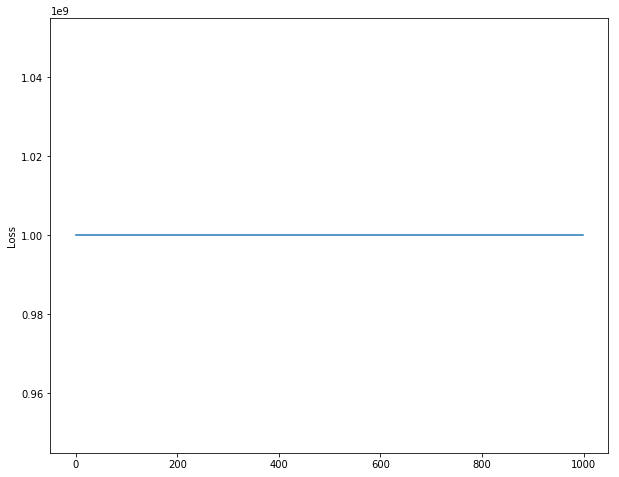

In [21]:
clf = SoftmaxClassifer(num_features, num_classes)
# TODO: Use cross-validations to find the optimal regularization_strength and step_size
opt = RandomSearch(classifier=clf, regularization_strength=0.000001)
loss_history = opt.train(X_train, y_train, nb_iter=1000, step_size=0.000001)
plt.plot(range(len(loss_history)), loss_history)
plt.ylabel('Iteration')
plt.ylabel('Loss')

print('Train accuracy:', accuracy_score(clf.predict(X_train), y_train))
#print('Val accuracy:', accuracy_score(clf.predict(X_val), y_val))
#print('Test accuracy:', accuracy_score(clf.predict(X_test), y_test))

In [ ]:
clf = SoftmaxClassifer(num_features, num_classes)
# TODO: Use cross-validations to find the optimal regularization_strength and step_size
opt = RandomLocalSearch(classifier=clf, regularization_strength=0.000001)
loss_history = opt.train(X_train, y_train, nb_iter=1000, step_size=0.000001)
plt.plot(range(len(loss_history)), loss_history)
plt.ylabel('Iteration')
plt.ylabel('Loss')

print('Train accuracy:', accuracy_score(clf.predict(X_train), y_train))
print('Val accuracy:', accuracy_score(clf.predict(X_val), y_val))
print('Test accuracy:', accuracy_score(clf.predict(X_test), y_test))

In [ ]:
clf = SoftmaxClassifer(num_features, num_classes)
# TODO: Use cross-validations to find the optimal regularization_strength and step_size
opt = GradientDescent(classifier=clf, regularization_strength=0.000001)
loss_history = opt.train(X_train, y_train, nb_iter=300, step_size=1e-8)
plt.plot(np.arange(len(loss_history)), loss_history)
plt.ylabel('Iteration')
plt.ylabel('Loss')

print('Train accuracy:', accuracy_score(clf.predict(X_train), y_train))
print('Val accuracy:', accuracy_score(clf.predict(X_val), y_val))
print('Test accuracy:', accuracy_score(clf.predict(X_test), y_test))

# Task 3: Numerical gradient computation

In [ ]:
def compute_numerical_gradient(f, x):
    """ 
    a naive implementation of numerical gradient of f at x 
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """ 

    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001
    
    #############################################################################
    # TODO: implement numerical gradient computation df/dx  
    # Numerical gradient computation might be very slow, since it requires loss
    # value computation for every dimension of point x.
    # Use tqdm to visualize the progress of the computation.
    #############################################################################
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    with tqdm(total=x.size) as pbar:
        
        while not it.finished:
            ix = it.multi_index
            # compute grad[ix] 
            grad[ix] = 0.0
            pass
            
            it.iternext() # step to next dimension
            pbar.update(1)
        
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
            
    

    return grad


# We need a single-argument loss function to use compute_numerical_gradient
def my_cifar10_loss_fn(W):
    return softmax_loss_vectorized(W, X_train, y_train, reg=0.0001)[0]


clf = SoftmaxClassifer(num_features, num_classes)
loss_initial = my_cifar10_loss_fn(clf.W) # the inital loss
print('Initial loss: %f' % (loss_initial, ))

# NOTE! May take up to 1-2 hours to compute! Be patient and use tqdm to track the progress
grad_f = compute_numerical_gradient(my_cifar10_loss_fn, clf.W)

best_loss = float("inf")
# lets see the effect of multiple step sizes
step_sizes = np.array([-10, -9, -8, -7, -6, -5, -4, -3, -2, -1])
loss_values = np.zeros_like(step_sizes, dtype=np.float)
for i, step_size_log in tqdm(enumerate(step_sizes)):
    step_size = 10. ** step_size_log
    W_new = clf.W - step_size * grad_f # new position in the weight space
    loss_values[i] = my_cifar10_loss_fn(W_new)
    if loss_values[i] < best_loss:
        clf.W = W_new
        best_loss = loss_values[i]
                
print('Best loss: %f (with step size %f)' % (best_loss, step_sizes[np.argmin(loss_values)]))
    
plt.plot(step_sizes, loss_values)
plt.ylabel('Gradiend descent Step size')
plt.ylabel('Loss')

print('Train accuracy:', accuracy_score(clf.predict(X_train), y_train))
print('Val accuracy:', accuracy_score(clf.predict(X_val), y_val))
print('Test accuracy:', accuracy_score(clf.predict(X_test), y_test))